In [217]:
# original code: https://github.com/dyhan0920/PyramidNet-PyTorch/blob/master/train.py

import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import resnet as RN
import pyramidnet as PYRM
import utils
import numpy as np

import warnings

warnings.filterwarnings("ignore")

model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))

parser = argparse.ArgumentParser(description='Cutmix PyTorch CIFAR-10, CIFAR-100 and ImageNet-1k Training')
parser.add_argument('--net_type', default='pyramidnet', type=str,
                    help='networktype: resnet, and pyamidnet')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch_size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--print-freq', '-p', default=1, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--depth', default=32, type=int,
                    help='depth of the network (default: 32)')
parser.add_argument('--no-bottleneck', dest='bottleneck', action='store_false',
                    help='to use basicblock for CIFAR datasets (default: bottleneck)')
parser.add_argument('--dataset', dest='dataset', default='imagenet', type=str,
                    help='dataset (options: cifar10, cifar100, and imagenet)')
parser.add_argument('--no-verbose', dest='verbose', action='store_false',
                    help='to print the status at every iteration')
parser.add_argument('--alpha', default=300, type=float,
                    help='number of new channel increases per depth (default: 300)')
parser.add_argument('--expname', default='TEST', type=str,
                    help='name of experiment')
parser.add_argument('--beta', default=0, type=float,
                    help='hyperparameter beta')
parser.add_argument('--cutmix_prob', default=0, type=float,
                    help='cutmix probability')

parser.set_defaults(bottleneck=True)
parser.set_defaults(verbose=True)

best_err1 = 100
best_err5 = 100

global args, best_err1, best_err5

args =  parser.parse_args(args=[])
args.dataset = 'cifar10'


if args.dataset.startswith('cifar'):
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    if args.dataset == 'cifar100':
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('../data', train=True, download=True, transform=transform_train),
            batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)
        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100('../data', train=False, transform=transform_test),
            batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)
        numberofclass = 100
    elif args.dataset == 'cifar10':
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('../data', train=True, download=True, transform=transform_train),
            batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)
        val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('../data', train=False, transform=transform_test),
            batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)
        numberofclass = 10
    else:
        raise Exception('unknown dataset: {}'.format(args.dataset))

elif args.dataset == 'imagenet':
    traindir = os.path.join('/home/data/ILSVRC/train')
    valdir = os.path.join('/home/data/ILSVRC/val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    jittering = utils.ColorJitter(brightness=0.4, contrast=0.4,
                                  saturation=0.4)
    lighting = utils.Lighting(alphastd=0.1,
                              eigval=[0.2175, 0.0188, 0.0045],
                              eigvec=[[-0.5675, 0.7192, 0.4009],
                                      [-0.5808, -0.0045, -0.8140],
                                      [-0.5836, -0.6948, 0.4203]])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            jittering,
            lighting,
            normalize,
        ]))

    train_sampler = None

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)
    numberofclass = 1000

else:
    raise Exception('unknown dataset: {}'.format(args.dataset))

print("=> creating model '{}'".format(args.net_type))
if args.net_type == 'resnet':
    model = RN.ResNet(args.dataset, args.depth, numberofclass, args.bottleneck,pretrained=False)  # for ResNet
elif args.net_type == 'pyramidnet':
    model = PYRM.PyramidNet(args.dataset, args.depth, args.alpha, numberofclass,
                            args.bottleneck)
else:
    raise Exception('unknown network architecture: {}'.format(args.net_type))

#model = torch.nn.DataParallel(model).cuda()

print(model)
print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()#.cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay, nesterov=True)

cudnn.benchmark = True

args.beta  = 1
args.cutmix_prob = 1



Files already downloaded and verified
=> creating model 'pyramidnet'
PyramidNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 49, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(49, 49, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(49, 196, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn4): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Bottleneck(
      (bn1): Bat

In [218]:
model.train()
current_LR = get_learning_rate(optimizer)[0]


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def validate(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda()

        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        err1, err5 = accuracy(output.data, target, topk=(1, 5))

        losses.update(loss.item(), input.size(0))

        top1.update(err1.item(), input.size(0))
        top5.update(err5.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0 and args.verbose == True:
            print('Test (on val set): [{0}/{1}][{2}/{3}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top 1-err {top1.val:.4f} ({top1.avg:.4f})\t'
                  'Top 5-err {top5.val:.4f} ({top5.avg:.4f})'.format(
                epoch, args.epochs, i, len(val_loader), batch_time=batch_time, loss=losses,
                top1=top1, top5=top5))

    print('* Epoch: [{0}/{1}]\t Top 1-err {top1.avg:.3f}  Top 5-err {top5.avg:.3f}\t Test Loss {loss.avg:.3f}'.format(
        epoch, args.epochs, top1=top1, top5=top5, loss=losses))
    return top1.avg, top5.avg, losses.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    directory = "runs/%s/" % (args.expname)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/%s/' % (args.expname) + 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if args.dataset.startswith('cifar'):
        lr = args.lr * (0.1 ** (epoch // (args.epochs * 0.5))) * (0.1 ** (epoch // (args.epochs * 0.75)))
    elif args.dataset == ('imagenet'):
        if args.epochs == 300:
            lr = args.lr * (0.1 ** (epoch // 75))
        else:
            lr = args.lr * (0.1 ** (epoch // 30))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def get_learning_rate(optimizer):
    lr = []
    for param_group in optimizer.param_groups:
        lr += [param_group['lr']]
    return lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res


In [219]:
in1 , tar1 = train_loader.dataset[0]
in2 , tar2 = train_loader.dataset[1]

target = torch.tensor([tar1,tar2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


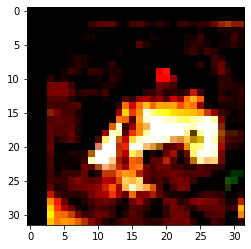

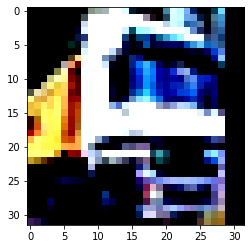

In [220]:
input = torch.stack([in1,in2])
input.shape
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(input[0].permute(1,2,0))
plt.figure()
plt.imshow(input[1].permute(1,2,0))


In [221]:
output1 = model(input)
output3= model(input)

In [222]:
r = np.random.rand(1)
if args.beta > 0 and r < args.cutmix_prob:
    # generate mixed sample
    lam = np.random.beta(args.beta, args.beta)
    rand_index = [1,0]
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = [0,0,10,10]
    input2 = torch.zeros_like(input)
    input2= input
    input2[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
    # compute output
    output2 = model(input2)
    #loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
    


In [223]:
input

tensor([[[[-0.4968, -0.7667, -1.1000,  ..., -1.9889, -1.9889, -1.9889],
          [-0.5286, -0.6556, -0.9571,  ..., -1.9889, -1.9889, -1.9889],
          [-0.5603, -0.6714, -0.9571,  ...,  0.6778,  0.5349,  0.5190],
          ...,
          [-1.9889, -1.9889, -1.9889,  ...,  0.1857,  0.2810,  1.2333],
          [-1.9889, -1.9889, -1.9889,  ...,  0.0270, -0.1794,  0.9635],
          [-1.9889, -1.9889, -1.9889,  ..., -0.5603, -1.1952,  0.1857]],

         [[-0.4348, -0.7246, -1.0628,  ..., -1.9807, -1.9807, -1.9807],
          [-0.4509, -0.5958, -0.9018,  ..., -1.9807, -1.9807, -1.9807],
          [-0.4831, -0.5958, -0.9018,  ...,  0.2093,  0.0966,  0.1127],
          ...,
          [-1.9807, -1.9807, -1.9807,  ..., -0.3543, -0.2576,  0.7085],
          [-1.9807, -1.9807, -1.9807,  ..., -0.3543, -0.5797,  0.5153],
          [-1.9807, -1.9807, -1.9807,  ..., -0.8696, -1.5942, -0.2899]],

         [[-0.4483, -0.6282, -0.8981,  ..., -1.7076, -1.7076, -1.7076],
          [-0.5082, -0.5682, -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


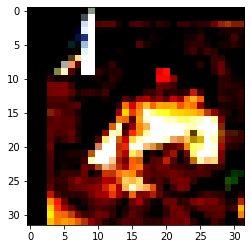

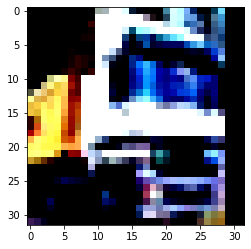

In [224]:
plt.figure()
plt.imshow(input2[0].permute(1,2,0))
plt.figure()
plt.imshow(input2[1].permute(1,2,0))


In [225]:
output1

tensor([[ 0.2711, -0.2325, -0.4196,  0.0606, -0.1891, -0.0977, -0.4141,  0.3660,
         -0.0800,  0.1803],
        [ 0.2535, -0.3143, -0.3893,  0.0478, -0.1216,  0.0741, -0.4035,  0.4093,
          0.0213,  0.2865]], grad_fn=<AddmmBackward0>)

In [226]:
output2

tensor([[ 0.3382, -0.2646, -0.3812,  0.0797, -0.1783, -0.1103, -0.3839,  0.4012,
         -0.1102,  0.1677],
        [ 0.1901, -0.2961, -0.4154,  0.0302, -0.1344,  0.0769, -0.4265,  0.3843,
          0.0595,  0.3018]], grad_fn=<AddmmBackward0>)

In [227]:
output3

tensor([[ 0.2711, -0.2325, -0.4196,  0.0606, -0.1891, -0.0977, -0.4141,  0.3660,
         -0.0800,  0.1803],
        [ 0.2535, -0.3143, -0.3893,  0.0478, -0.1216,  0.0741, -0.4035,  0.4093,
          0.0213,  0.2865]], grad_fn=<AddmmBackward0>)

In [195]:
#loss = criterion(output, target)


# measure accuracy and record loss
err1, err5 = accuracy(output.data, target, topk=(1, 5))

losses.update(loss.item(), input.size(0))
top1.update(err1.item(), input.size(0))
top5.update(err5.item(), input.size(0))

# compute gradient and do SGD step
optimizer.zero_grad()
loss.backward()
optimizer.step()

# measure elapsed time
batch_time.update(time.time() - end)
end = time.time()

if i % args.print_freq == 0 and args.verbose == True:
    print('Epoch: [{0}/{1}][{2}/{3}]\t'
          'LR: {LR:.6f}\t'
          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
          'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
          'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
          'Top 1-err {top1.val:.4f} ({top1.avg:.4f})\t'
          'Top 5-err {top5.val:.4f} ({top5.avg:.4f})'.format(
        epoch, args.epochs, i, len(train_loader), LR=current_LR, batch_time=batch_time,
        data_time=data_time, loss=losses, top1=top1, top5=top5))

print('* Epoch: [{0}/{1}]\t Top 1-err {top1.avg:.3f}  Top 5-err {top5.avg:.3f}\t Train Loss {loss.avg:.3f}'.format(
epoch, args.epochs, top1=top1, top5=top5, loss=losses))



NameError: name 'output' is not defined

In [6]:
import os 
resnet_cutmix_path = '/home/raz.adi/advanced-dl-final-project/CutMix/runs/resnet101CutMix'
model_name = 'model_best.pth.tar'
ckp_name = 'checkpoint.pth.tar'



NameError: name 'args' is not defined

dict_keys(['epoch', 'arch', 'state_dict', 'best_err1', 'best_err5', 'optimizer'])